In [1]:
import os
import scanpy
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import re
import sklearn
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from collections import Counter
import random
import seaborn
import sys
import shutil
import scvelo as scv
import bbknn
import tqdm
#Load my pipeline functions
import importlib
import importlib.util
spec = importlib.util.spec_from_file_location("ScanpyUtilsMT", os.path.expanduser("../../utils/ScanpyUtilsMT.py"))
sc_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sc_utils)
sc.settings.figdir='/wynton/group/ye/mtschmitz/figures/macWbSupervise/'
scv.settings.figdir='/wynton/group/ye/mtschmitz/figures/macWbSupervise/'
sc.settings.file_format_figs='pdf'
sc.settings.autosave=False
sc.settings.autoshow=True

In [154]:
#newfile='/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityMacaqueWbPresuperviseProcessed.h5ad'
newfile='/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityPanHumanPresuperviseProcessed.h5ad'
newfile='/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityMouseWbPresupervisionhb_subset.h5ad'

adata=sc.read(newfile)


In [155]:
adata

AnnData object with n_obs × n_vars = 79185 × 33340
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'batch', 'clean_cellname', 'full_cellname', 'msregion', 'general_region', 'leiden', 'supervised_name', 'percent_ribo', 'percent_mito'
    var: 'feature_type-0', 'id-0', 'name-0', 'feature_type-1-0', 'id-1-0', 'name-1-0', 'feature_type-1-1', 'id-1-1', 'name-1-1', 'feature_type-1-10', 'id-1-10', 'name-1-10', 'feature_type-1-100', 'id-1-100', 'name-1-100', 'feature_type-1-101', 'id-1-101', 'name-1-101', 'feature_type-1-102', 'id-1-102', 'name-1-102', 'feature_type-1-103', 'id-1-103', 'name-1-103', 'feature_type-1-104', 'id-1-104', 'name-1-104', 'feature_type-1-105', 'id-1-105', 'name-1-105', 'feature_type-1-106', 'id-1-106', 'name-1-106', 'feature_type-1-107', 'id-1-107', 'name-1-107', 'feature_type-1-108', 'id-1-108', 'name-1-108', 'feature_type-1-109', 'id-1-109', 'name-1-109', 'feature_type-1-11', 'id-1-11', 'name

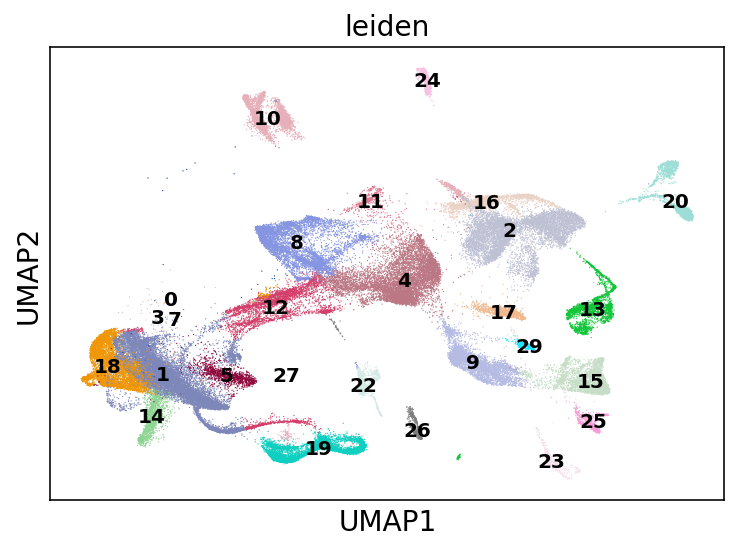

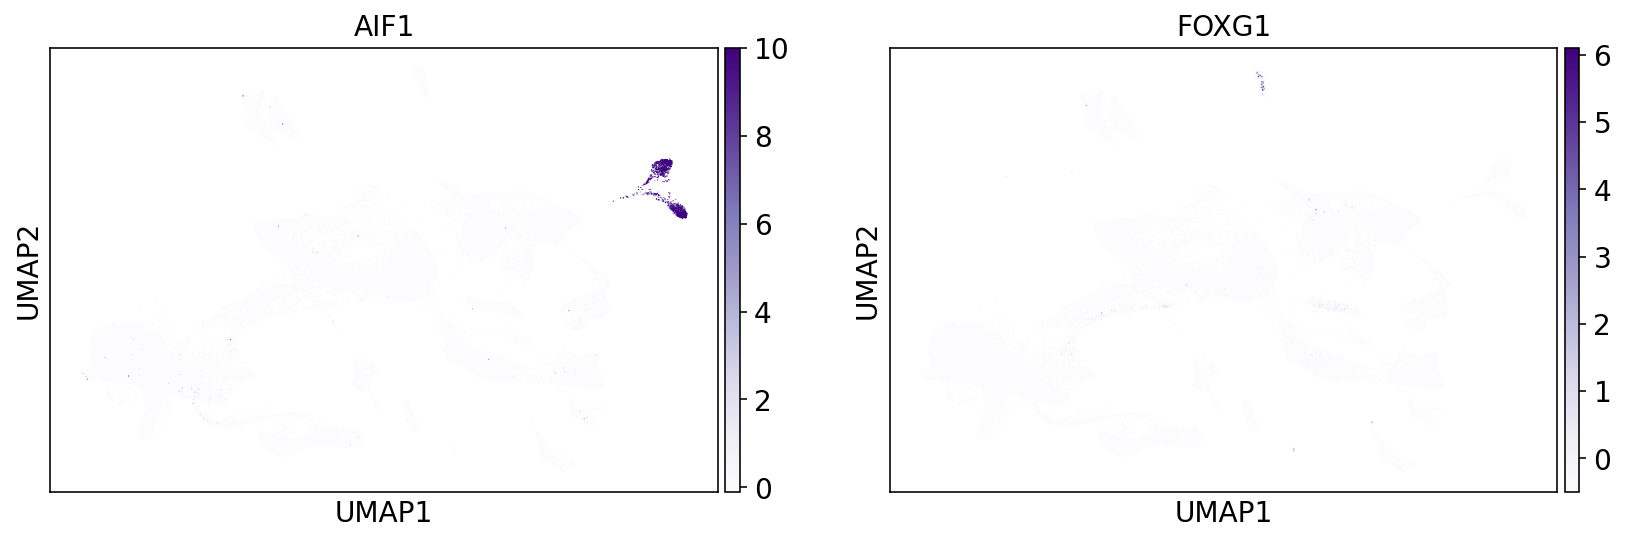

In [156]:
%matplotlib inline
sc.pl.umap(adata,color='leiden', legend_loc='on data')
sc.pl.umap(adata,color=['AIF1','FOXG1'],use_raw=False)

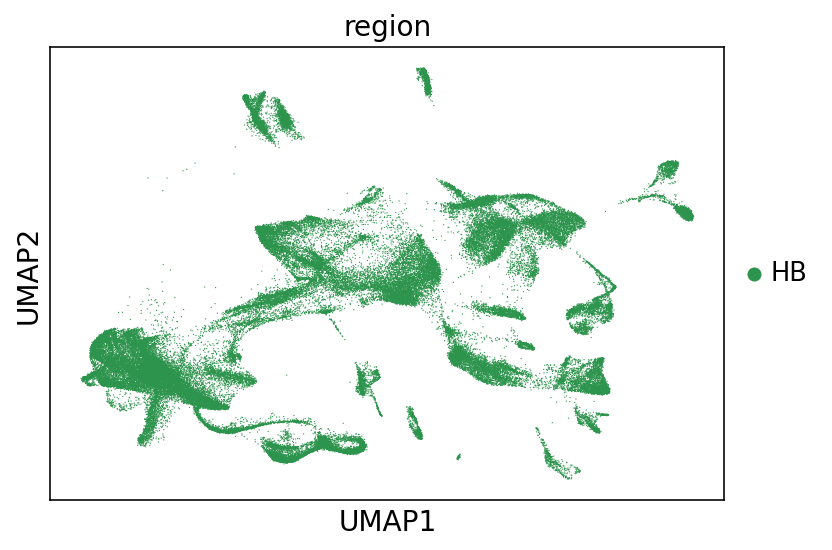

In [157]:
%matplotlib inline
sc.pl.umap(adata,color='region')

In [158]:
import hotspot

In [159]:
adata.X=adata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]

In [128]:
sc.pp.filter_genes(adata,min_cells=500,inplace=True)
sc.pp.filter_genes_dispersion(adata,n_top_genes=10000,flavor='seurat_v3')

ValueError: `flavor` needs to be "seurat" or "cell_ranger"

In [129]:
adata

AnnData object with n_obs × n_vars = 79185 × 14405
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'batch', 'clean_cellname', 'full_cellname', 'msregion', 'general_region', 'leiden', 'supervised_name', 'percent_ribo', 'percent_mito'
    var: 'feature_type-0', 'id-0', 'name-0', 'feature_type-1-0', 'id-1-0', 'name-1-0', 'feature_type-1-1', 'id-1-1', 'name-1-1', 'feature_type-1-10', 'id-1-10', 'name-1-10', 'feature_type-1-100', 'id-1-100', 'name-1-100', 'feature_type-1-101', 'id-1-101', 'name-1-101', 'feature_type-1-102', 'id-1-102', 'name-1-102', 'feature_type-1-103', 'id-1-103', 'name-1-103', 'feature_type-1-104', 'id-1-104', 'name-1-104', 'feature_type-1-105', 'id-1-105', 'name-1-105', 'feature_type-1-106', 'id-1-106', 'name-1-106', 'feature_type-1-107', 'id-1-107', 'name-1-107', 'feature_type-1-108', 'id-1-108', 'name-1-108', 'feature_type-1-109', 'id-1-109', 'name-1-109', 'feature_type-1-11', 'id-1-11', 'name

In [181]:
adata=adata[0:2000,:]

In [194]:
hopot=hotspot.Hotspot(counts=pd.DataFrame(adata.X.todense().T),latent=pd.DataFrame(adata.obsm['X_pca']),umi_counts=pd.Series(adata.X.sum(1).A1))


Removing 9621 undetected/non-varying genes


In [162]:
nz=adata.obsp['distances'].nonzero()
ncols=pd.DataFrame(nz[0]).value_counts().max()
df=pd.DataFrame(index=set(nz[0]),columns=list(range(ncols)))
count=0
this_x=None
for x,y in tqdm.tqdm(zip(nz[0],nz[1])):
    if x==this_x:
        count+=1
    else:
        count=0
    df.loc[x,count]=y
    this_x=x


5622135it [06:51, 13649.47it/s]


In [163]:
hopot.neighbors=df

In [164]:
nz=adata.obsp['distances'].nonzero()
ncols=pd.DataFrame(nz[0]).value_counts().max()
df=pd.DataFrame(index=set(nz[0]),columns=list(range(ncols)))
count=0
this_x=None
for x,y in tqdm.tqdm(zip(nz[0],nz[1])):
    if x==this_x:
        count+=1
    else:
        count=0
    df.loc[x,count]=adata.obsp['distances'][x,y]
    this_x=x


5622135it [12:02, 7777.91it/s]


In [165]:
hopot.weights=df

In [183]:
hopot.create_knn_graph()

In [193]:
hopot.neighbors.astype(int).dtypes

0     int64
1     int64
2     int64
3     int64
4     int64
5     int64
6     int64
7     int64
8     int64
9     int64
10    int64
11    int64
12    int64
13    int64
14    int64
15    int64
16    int64
17    int64
18    int64
19    int64
20    int64
21    int64
22    int64
23    int64
24    int64
25    int64
26    int64
27    int64
28    int64
29    int64
dtype: object

In [192]:
hopot.weights.astype(float).dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
28    float64
29    float64
dtype: object

In [185]:
hopot.graph

In [191]:
hopot.tree

In [49]:
#hopot.neighbors=adata.obsp['connectivities'].nonzero()
#hopot.weights=adata.obsp['connectivities']



In [150]:
hopot.neighbors.dtypes

0     int64
1     int64
2     int64
3     int64
4     int64
5     int64
6     int64
7     int64
8     int64
9     int64
10    int64
11    int64
12    int64
13    int64
14    int64
15    int64
16    int64
17    int64
18    int64
19    int64
20    int64
21    int64
22    int64
23    int64
24    int64
25    int64
26    int64
27    int64
28    int64
29    int64
dtype: object

In [151]:
hopot.weights.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
28    float64
29    float64
dtype: object

In [176]:
hopot.compute_hotspot(jobs=1)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type array(pyobject, 2d, F)
During: typing of argument at /wynton/home/ye/mschmitz1/utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/hotspot/knn.py (106)

File "../../../../utils/miniconda3/envs/scanpy/lib/python3.9/site-packages/hotspot/knn.py", line 106:
def compute_node_degree(neighbors, weights):
    <source elided>

    D = np.zeros(neighbors.shape[0])
    ^


In [65]:
adata.obsp['connectivities'].nonzero()

(array([   0,    0,    0, ..., 1999, 1999, 1999], dtype=int32),
 array([   3,   54,  249, ...,  847, 1908, 1936], dtype=int32))

In [69]:
np.where((adata.obsp['connectivities']!=0).todense())

(array([   0,    0,    0, ..., 1999, 1999, 1999]),
 array([   3,   54,  249, ...,  847, 1908, 1936]))

In [76]:
hopot.neighbors

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,3,54,249,1228,793,1650,1021,453,566,992,...,755,1303,1529,1958,1953,1838,1841,1478,1455,870
1,124,191,193,1825,442,555,372,188,764,360,...,501,930,9,615,483,233,168,1915,851,1176
2,40,55,44,1581,1326,690,809,400,441,472,...,154,681,8,481,15,58,554,446,120,102
3,0,54,249,1228,773,946,793,453,765,1021,...,1953,730,791,906,1505,1552,196,1982,1882,1787
4,144,59,463,283,141,285,69,29,215,258,...,293,428,371,79,512,200,850,600,651,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1293,1111,1256,1405,740,907,556,328,1934,1300,...,1417,1045,840,1154,1035,1377,586,859,1547,1697
1996,1913,870,1620,1552,1303,471,1423,495,1957,1529,...,132,1982,1882,227,525,759,755,1125,1321,1170
1997,1574,1427,1715,1842,1797,484,496,1503,227,1792,...,495,1924,1356,1423,1745,260,72,414,1847,1005
1998,1481,1914,1836,1909,1484,1785,1896,1248,1068,1907,...,1701,1435,1421,1291,1181,1940,1262,810,1731,1603


In [113]:
hopot.weights

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0
3,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0
4,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


In [114]:
ncols

2

In [115]:
adata.obsp['distances']

<2000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 3485 stored elements in Compressed Sparse Row format>

In [116]:
ncols=pd.DataFrame(nz[0]).value_counts().max()


In [119]:
ncols

2

In [118]:
df

,0,1
0,3,54
1,124,191
2,40,55
3,0,54
4,59,258
...,...,...
1990,936,1610
1993,1229,1368
1994,849,NaN
1995,1293,NaN
